# "[DL] 딥러닝 입문2"
> "보스턴 주택 가격 예측하기"

- toc: true
- branch: master
- badges: true
- comments: true
- categories: [DL, Pytorch]
- author: 도형준

# 보스턴 주택 가격 예측하기

## 데이터 적재

In [ ]:
from sklearn.datasets import load_boston

dataset = load_boston()
print(dataset.keys())

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename', 'data_module'])


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

In [ ]:
import pandas as pd
df = pd.DataFrame(dataset["data"])
df.columns = dataset["feature_names"]
df['target'] = dataset["target"]
# data: 독립변수들(features)
# target: 종속변수, 예측 대상
# feature_names: columns name
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


## 학습 루프
* 모델 정의 ->  [데이터 불러오기 -> 손실(에러) 계산 -> 오차 역전파 및 최적화] (만족할때 까지 반복) -> 학습완료

## 모델 정의(선형 회귀)
> 데이터를 직선으로 관계를 나타내는 방법<br>
> 데이터를 y와 x의 관계로 표현되는 직선으로 나타내는 방법
- 회귀에 의해 얻은 결과를 실제 데이터(target)와 비교 & 오차를 줄여나가는 방식으로 학습
- MSE(Mean Squared Error, 평균제곱오차): 작은 오차와 큰 오차를 강하게 대비시킬 수 있어서 유용

- torch.nn.Sequential(): 객체에 모듈(선형 회귀)을 집어 넣어주면, PyTorch가 알아서 순서대로 처리(계산)
- torch.nn.Linear(선형회귀모델)

![MLP](https://i.imgur.com/ISxVoTq.png)
- 선형 회귀에 이용할 다층 신경망 구조(MLP)
- MLP층은 각 층의 뉴런이 다음 층의 모든 뉴런과 연결되어 있기 때문에 완전연결층(fully connected layer,FC)라고도 불림.
  1. 먼저 입력층에 입력 데이터가 들어옴.
  2. 은닉층에 전달 -> 입력 데이터의 특징으로 정보를 추출
  3. 출력층에 전달 -> 예측값 <-> 실제 정답을 비교 손실을 계산<br>
  (정보가 입력층에서 출력층까지 흘러감 = 순전파)
  4. 손실을 계산하고 가중치를 수정하기 위해 오차를 역전파
  ---

## 배치와 에포크
- 컴퓨터의 메모리(한정) > 한번에 처리X -> 전체 데이터를 나눠서 학습<br>
(학습하는 단위: 배치((batch))
- 배치: 딥러닝 모델의 가중치(손실 보정)를 업데이트 시킬 때 사용되는 데이터의 묶음 단위
- 에포크: 배치의 크기 단위로 전체 데이터를 모두 학습하는 단위
- 이터레이션(iteration): 1에포크를 완성시키는 데 필요한 배치의 반복 횟수<br>
예) 1에포크 = 1000개 / 배치 = 50개 / 이터레이션 = 20회
> 에포크 = 배치 * 이터레이션
---

In [ ]:
import torch
import torch.nn as nn ## nn:인공신경망

from torch.optim.adam import Adam # 옵티마이저

In [ ]:
model = nn.Sequential(
    # 입력층 = 독립변수(X)의 수
    nn.Linear(13,100),
    # 활성화 함수
    nn.ReLU(),
    # 출력층
    nn.Linear(100,1)
)

In [ ]:
model

Sequential(
  (0): Linear(in_features=13, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=1, bias=True)
)

In [ ]:
X = df.iloc[:, :13].values # df.drop('target', axis=1).values
Y = df.target.values

In [ ]:
batch_size = 100 # 손실 가중치 업데이트 할 때 반영할 데이터 단위
learning_rate = 0.001 # 학습률

In [ ]:
# 가중치를 수정하는 최적화 함수 정의
optim = Adam(model.parameters(),lr = learning_rate)

In [ ]:
# 에포크 반복
for epoch in range(200):
    # 배치 반복
    for i in range(len(X) // batch_size):
        start = i * batch_size
        end = start + batch_size
        # 파이토치 실수형 텐서로 변환
        x = torch.FloatTensor(X[start:end])
        y = torch.FloatTensor(Y[start:end])
        optim.zero_grad() # 가중치의 기울기를 0으로 초기화
        preds = model(x) # 모델의 예측값
        loss = nn.MSELoss()(preds, y) # MSE 손실(에러) 계산
        loss.backward() # 오차 역전파
        optim.step() # 최적화
    if epoch % 20 == 0:
        print(f"epoch{epoch} loss:{loss.item()}")

epoch0 loss:37.51952362060547
epoch20 loss:37.484703063964844
epoch40 loss:37.4303092956543
epoch60 loss:37.37458419799805
epoch80 loss:37.35523986816406
epoch100 loss:37.308284759521484
epoch120 loss:37.29677200317383
epoch140 loss:37.22688674926758
epoch160 loss:37.199676513671875
epoch180 loss:37.11103820800781


In [ ]:
type(preds),type(y)

(torch.Tensor, torch.Tensor)

In [ ]:
prediction = model(torch.FloatTensor(X[0,:13]))
real = Y[0]
print(f"prediction: {prediction.item()} real: {real}")

prediction: 24.306076049804688 real: 24.0


In [ ]:
def compare(row_num):
    prediction = model(torch.FloatTensor(X[row_num, :13]))
    real = Y[row_num]
    print(f"prediction : {prediction.item()} real: {real}")
    return ()

In [ ]:
[compare(i) for i in range(len(X))]

prediction : 24.306076049804688 real: 24.0
prediction : 24.747642517089844 real: 21.6
prediction : 23.894947052001953 real: 34.7
prediction : 22.526775360107422 real: 33.4
prediction : 22.86405372619629 real: 36.2
prediction : 22.689878463745117 real: 28.7
prediction : 24.987817764282227 real: 22.9
prediction : 25.32816505432129 real: 27.1
prediction : 24.568233489990234 real: 16.5
prediction : 24.287317276000977 real: 18.9
prediction : 24.957286834716797 real: 15.0
prediction : 24.953201293945312 real: 18.9
prediction : 25.38256072998047 real: 21.7
prediction : 24.37371063232422 real: 20.4
prediction : 23.846899032592773 real: 18.2
prediction : 24.27907943725586 real: 19.9
prediction : 24.75175666809082 real: 23.1
prediction : 23.886117935180664 real: 17.5
prediction : 15.853653907775879 real: 20.2
prediction : 24.10258674621582 real: 18.2
prediction : 23.560503005981445 real: 13.6
prediction : 24.49432945251465 real: 19.6
prediction : 24.657207489013672 real: 15.2
prediction : 24.782

[(),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),


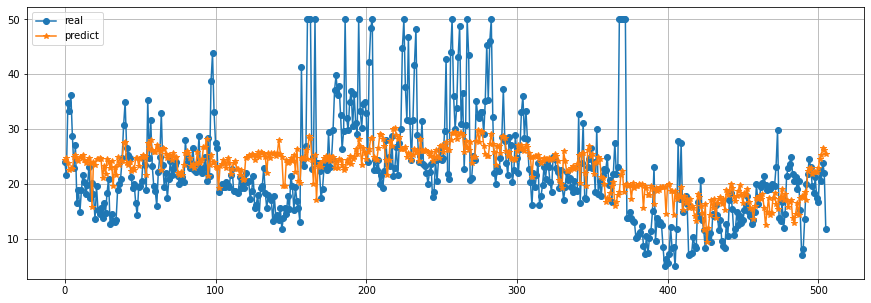

In [ ]:
import seaborn as sns
num = 0
num_list = []
real_list = []
pred_num_list = []
error_list = []

for i in range(len(X)):
  prediction = model(torch.FloatTensor(X[i, :13]))
  real = Y[i]
  pred_num = prediction.item()
  num_list.append(num)
  real_list.append(real)
  pred_num_list.append(pred_num)
  num +=1

plt.figure(figsize=(15,5))
plt.plot(num_list, real_list,'-o', label='real')
plt.plot(num_list, pred_num_list,'-*', label='predict')
plt.grid()
plt.legend(loc='upper left')

In [ ]:
import plotly.express as px

num = 0
num_list = []
real_list = []
pred_num_list = []
error_list = []

for i in range(len(X)):
  prediction = model(torch.FloatTensor(X[i, :13]))
  real = Y[i]
  pred_num = prediction.item()
  error = real - pred_num
  
  num_list.append(num)
  real_list.append(real)
  pred_num_list.append(pred_num)
  error_list.append)(error)
  num +=1

fig = px.scatter(x= num_list, y= real_list, color="species",
                 error_x="e", error_y="e")
fig.show()